Occupancy plots with Python and ggplot2 via rmagic - Part 3a
=============================================================

## Background ##

In two previous posts ([here](http://hselab.org/content/occupancy-analysis-python-pandas-part-1-create-date-data-frame) and [here](http://hselab.org/content/occupancy-analysis-python-pandas-part-2-compute-occupancy-summary-stats)), I showed how to do occupancy analysis with the beginnings of a Python based version of [Hillmaker](http://hillmaker.sourceforge.net/). The example is based on data from a hospital short stay unit.

In this short tutorial, I'll show how to use `rmagic` from within an IPython notebook so that we can make occupancy plots using `ggplot2`. In particular, we want to create a grid of occupancy histograms with one grid axis being patient type and the other axis being day of week. We want to make sure that the plots are ordered Sunday, Monday, ..., Saturday and NOT in alphabetical order (Friday, Monday, ..., Wednesday).

The first part of such an analysis leads to a table we call the "by datetime" table. At the end of Part 1 of this tutorial series, we ended up with a csv file called bydate_shortstay_csv.csv. Let's read it in and take a look at it.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Make the graphs a bit prettier, and bigger
pd.set_option('display.mpl_style', 'default') 
pd.set_option('display.line_width', 5000) 
pd.set_option('display.max_columns', 60) 

line_width has been deprecated, use display.width instead (currently both are
identical)



/home/mark/anaconda3/envs/hselab/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2881: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
## Read sample data set and convert string dates to datetimes
bydatetime_df = pd.read_csv('bydate_shortstay_demo.csv',parse_dates=['datetime'])

In [3]:
bydatetime_df.head()

category            datetime  arrivals  binofday  binofweek  dayofweek  departures  occupancy
0      IVT 1996-01-07 00:00:00       0.0       0.0      288.0        6.0         0.0        0.0
1      IVT 1996-01-07 00:30:00       0.0       1.0      289.0        6.0         1.0        0.5
2      IVT 1996-01-07 01:00:00       0.0       2.0      290.0        6.0         0.0        0.0
3      IVT 1996-01-07 01:30:00       0.0       3.0      291.0        6.0         0.0        0.0
4      IVT 1996-01-07 02:00:00       0.0       4.0      292.0        6.0         0.0        0.0

Let's say that we are interested in average occupancy by day of week (ignoring time of day) by patient type (category). Since each day consists of the same number of equally sized time bins, we can use the Pandas `groupby` function to easily compute mean occupancy by day of week.

In [4]:
meanocc_df = bydatetime_df.groupby(['category','dayofweek'])['occupancy'].mean()

In [5]:
meanocc_df

category  dayofweek
ART       0.0           1.841435
          1.0           1.700810
          2.0           1.770544
          3.0           1.868866
          4.0           2.144907
          5.0           0.000000
          6.0           0.000000
CAT       0.0           2.562963
          1.0           2.055556
          2.0           2.181134
          3.0           2.136053
          4.0           2.540683
          5.0           0.620833
          6.0           0.278312
IVT       0.0           8.670891
          1.0           7.403183
          2.0           7.350810
          3.0           7.557870
          4.0           9.250231
          5.0           0.969792
          6.0           0.283494
MYE       0.0           2.056250
          1.0           1.873669
          2.0           1.841030
          3.0           1.826505
          4.0           2.022743
          5.0           0.147280
          6.0           0.091293
OTH       0.0           1.455093
          1.0          

Even better than just the means would be occupancy histograms by patient type and day of week. That will require a little more work. On the way we'll see how to access individual levels of a hierarchical index, how to push data into an R workspace and use ggplot2 to make nice plots.

Let's start by computing average occupancy by category by date (i.e. roll up over the time bins).

In [6]:
meanoccdate = bydatetime_df.groupby(['category',bydatetime_df['datetime'].map(lambda x: x.date())])['occupancy'].mean()

In [7]:
meanoccdate.head()

category  datetime  
ART       1996-01-07    0.000000
          1996-01-08    1.732639
          1996-01-09    1.532639
          1996-01-10    1.541667
          1996-01-11    1.872222
Name: occupancy, dtype: float64

Now we can use this to create a grid of histograms of occupancy by category and day of week. To make our life a little easier, let's add a string day of week column to this new dataframe (yes, the output of the `groupby` is a `DataFrame` or `Series`). This will require us to access the datetime level of the hierarchical index of our `Series` object, meanoccdate. What does the index look like for one specific row in meanoccdate?

In [8]:
meanoccdate.index[0]

('ART', datetime.date(1996, 1, 7))

It's a tuple with the index values for each level of the hierarchy. We want the 2nd element in the tuple.

In [9]:
meanoccdate.index[0][1]

datetime.date(1996, 1, 7)

Ok, we've got that part. Now, how to convert a `Timestamp` (equivalently, a `datetime`), to its day of week label? Reading the [datetime docs](https://docs.python.org/2/library/datetime.html) leads to the `strftime` function for creating formatted string representations of datetimes.

In [10]:
ts = pd.Timestamp('6/26/2014')

In [11]:
ts.strftime('%a')

'Thu'

Great. Now just put it all together.

In [12]:
meanoccdate_df = pd.DataFrame(meanoccdate)

In [13]:
meanoccdate_df['dayofweek'] = meanoccdate_df.index.map(lambda x: pd.Timestamp(x[1]).strftime('%a'))

In [14]:
meanoccdate_df.head()

occupancy dayofweek
category datetime                       
ART      1996-01-07   0.000000       Sun
         1996-01-08   1.732639       Mon
         1996-01-09   1.532639       Tue
         1996-01-10   1.541667       Wed
         1996-01-11   1.872222       Thu

In [15]:
meanoccdate_df.tail()

occupancy dayofweek
category datetime                       
Total    1996-03-27  15.801389       Wed
         1996-03-28  13.538194       Thu
         1996-03-29  18.146528       Fri
         1996-03-30   1.436111       Sat
         1996-03-31   0.227083       Sun

In [16]:
meanoccdate_df['occupancy']['Total']

datetime
1996-01-07     0.871528
1996-01-08    17.759028
1996-01-09    15.146528
1996-01-10    14.095139
1996-01-11    16.148611
1996-01-12    16.236111
1996-01-13     1.586806
1996-01-14     0.725694
1996-01-15    18.181250
1996-01-16    16.000000
1996-01-17    14.304861
1996-01-18    16.816667
1996-01-19    16.011111
1996-01-20     2.631944
1996-01-21     0.682639
1996-01-22    18.025694
1996-01-23    14.714583
1996-01-24    13.429861
1996-01-25    13.356250
1996-01-26    16.219444
1996-01-27     1.819444
1996-01-28     0.809028
1996-01-29    17.865972
1996-01-30    13.149306
1996-01-31    13.804167
1996-02-01    15.036806
1996-02-02    16.986111
1996-02-03     1.595833
1996-02-04     0.506944
1996-02-05    16.199306
                ...    
1996-03-02     1.603472
1996-03-03     0.893750
1996-03-04    14.081250
1996-03-05    14.688889
1996-03-06    17.253472
1996-03-07    17.550000
1996-03-08    18.040278
1996-03-09     2.081944
1996-03-10     0.577778
1996-03-11    16.093056
1996-03

Exploring rmagic - a prelude to graphing occupancy
--------------------------------------------------

The *rmagic* extension allows us to magically use R from within IPython. Well, [it's not really magic](http://ipython.org/ipython-doc/dev/config/extensions/rmagic.html). It relies on the [RPy2](http://rpy.sourceforge.net/) Python module.

http://nbviewer.ipython.org/github/ipython/ipython/blob/3607712653c66d63e0d7f13f073bde8c0f209ba8/docs/examples/notebooks/rmagic_extension.ipynb

After loading the `rmagic` extension, you can use `%R` for a single R *line magic* command or `%%R` for *cell magic* to handle a sequence of R commands.

In [17]:
# Load the extension
%load_ext rpy2.ipython

In [18]:
%matplotlib inline

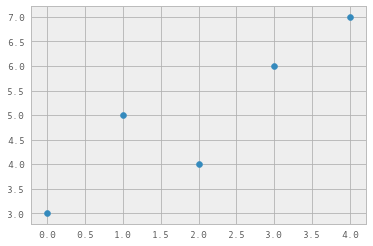

In [19]:
# Create some data in Python and scatter it

import pylab
X = np.array([0,1,2,3,4])
Y = np.array([3,5,4,6,7])
pylab.scatter(X, Y)

In [20]:
# "Push" these two numpy arrays into the R "space"
%Rpush X Y

In [21]:
%%R
linmodel <- lm(Y~X)
print(summary(linmodel))


Call:
lm(formula = Y ~ X)

Residuals:
   1    2    3    4    5 
-0.2  0.9 -1.0  0.1  0.2 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)   3.2000     0.6164   5.191   0.0139 *
X             0.9000     0.2517   3.576   0.0374 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7958 on 3 degrees of freedom
Multiple R-squared:   0.81,	Adjusted R-squared:  0.7467 
F-statistic: 12.79 on 1 and 3 DF,  p-value: 0.03739



So, pretty easy to run R commands from within IPython notebooks. Now let's exploit rmagic to do some ggplotting.

### Occupancy Histograms ###

A popular plotting module for Python is [matplotlib](http://matplotlib.org/). The project homepage has many links to resources for learning it, with a very good place to start
being the official [documentation](http://matplotlib.org/contents.html) and the [gallery of graphs](http://matplotlib.org/gallery.html). The are a few modes of using matplotlib. There is a **pyplot** mode which is particularly well suited for interactive plotting
in a Python shell like [IPython](http://ipython.org/) (much like one would work in Mathematica or MATLAB). You can also use matplotlib within Python scripts either with
the pyplot commands or via an objected oriented API (similar to [ggplot2](http://ggplot2.org/) for plotting in [R](http://www.r-project.org/)).

Here is a basic histogram for overall occupancy (there's a 'Total' cateogry in our data frame). For a more API based approach, see [this example from the matplotlib page](http://matplotlib.org/examples/api/histogram_demo.html) as
well as the next version of our histogram below.

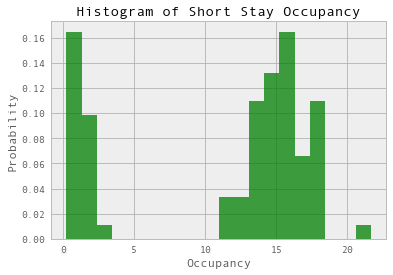

In [22]:
# normed=1 plots probs instead of counts, alpha in [0,1] is transparency level (RGBA colors)
plt.hist(meanoccdate_df['occupancy']['Total'], 20, normed=1, facecolor='green', alpha=0.75) 
plt.xlabel('Occupancy')
plt.ylabel('Probability')
plt.title(r'Histogram of Short Stay Occupancy')
plt.grid(True)
plt.show()

Clearly there's a day of the week effect - the lower mode is due to the weekends.


Now, let's create the same plot, but using R's `ggplot2` package. Our basic strategy is:

- use the `%Rpush` command to "push" the meanoccdate_df `DataFrame` into the R workspace.
- use `%R` line magic to load the `ggplot2` library
- use `%%R` cell magic to create and show the plot

A big question is, what happens to the hiearchical index in the pandas `DataFrame` when pushed to R?

In [23]:
%Rpush meanoccdate_df
%R str(meanoccdate_df)

'data.frame':	510 obs. of  2 variables:
 $ occupancy: num  0 1.73 1.53 1.54 1.87 ...
 $ dayofweek: chr  "Sun" "Mon" "Tue" "Wed" ...


Bummer, the category (patient type) and date fields that made up the pandas `MultiIndex` did not come through. No problem, we'll just create columns from the index before pushing the data frame to R.

In [24]:
meanoccdate_df['patient_type'] = meanoccdate_df.index.map(lambda x: x[0])
meanoccdate_df['date'] = meanoccdate_df.index.map(lambda x: x[1])

In [25]:
%Rpush meanoccdate_df
%R str(meanoccdate_df)

/home/mark/anaconda3/envs/hselab/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:61: UserWarning: Error while trying to convert the column "date". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'datetime.date'>'
  (name, str(e)))


'data.frame':	510 obs. of  4 variables:
 $ occupancy   : num  0 1.73 1.53 1.54 1.87 ...
 $ dayofweek   : chr  "Sun" "Mon" "Tue" "Wed" ...
 $ patient_type: chr  "ART" "ART" "ART" "ART" ...
 $ date        : chr  "1996-01-07" "1996-01-08" "1996-01-09" "1996-01-10" ...


In [26]:
%R library(ggplot2)

/home/mark/anaconda3/envs/hselab/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Use suppressPackageStartupMessages() to eliminate package startup
messages.

  warnings.warn(x, RRuntimeWarning)


array(['ggplot2', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'],
      dtype='<U9')

/home/mark/anaconda3/envs/hselab/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

  warnings.warn(x, RRuntimeWarning)


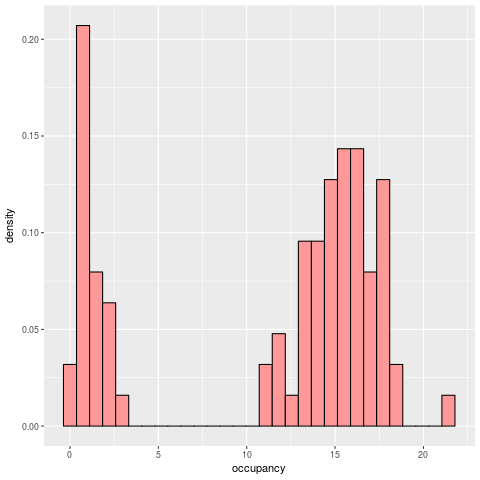

In [27]:
%%R
g <- ggplot(data=meanoccdate_df[meanoccdate_df$patient_type == 'Total',]) + geom_histogram(aes(x=occupancy, y=..density..), fill="#FF9999", colour="black")
print(g)

Now let's do a facet plot by patient_type and day of week.

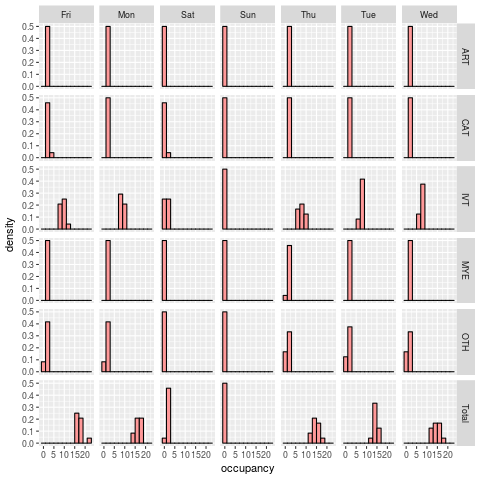

In [28]:
%%R
g2 <- ggplot(data=meanoccdate_df) + geom_histogram(aes(x=occupancy, y=..density..), binwidth=2, fill="#FF9999", colour="black")
print(g2 + facet_grid(patient_type ~ dayofweek))

Notice that the days of the week are not sorted correctly. Why? Recall the structure of our R `data.frame`.

In [29]:
%R str(meanoccdate_df)

'data.frame':	510 obs. of  4 variables:
 $ occupancy   : num  0 1.73 1.53 1.54 1.87 ...
 $ dayofweek   : chr  "Sun" "Mon" "Tue" "Wed" ...
 $ patient_type: chr  "ART" "ART" "ART" "ART" ...
 $ date        : chr  "1996-01-07" "1996-01-08" "1996-01-09" "1996-01-10" ...


The dayofweek column is a Factor. We want it to be an Ordered Factor and we want to tell R the order to use.

In [30]:
%%R
# Create vector with DOWs ordered as you wish
DOW_order <- c("Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat")

# Change DOW from factor to ordered factor using vector you just made
meanoccdate_df$dayofweek <- factor(meanoccdate_df$dayofweek,levels=DOW_order,ordered=TRUE)

In [31]:
%R str(meanoccdate_df)

'data.frame':	510 obs. of  4 variables:
 $ occupancy   : num  0 1.73 1.53 1.54 1.87 ...
 $ dayofweek   : Ord.factor w/ 7 levels "Sun"<"Mon"<"Tue"<..: 1 2 3 4 5 6 7 1 2 3 ...
 $ patient_type: chr  "ART" "ART" "ART" "ART" ...
 $ date        : chr  "1996-01-07" "1996-01-08" "1996-01-09" "1996-01-10" ...


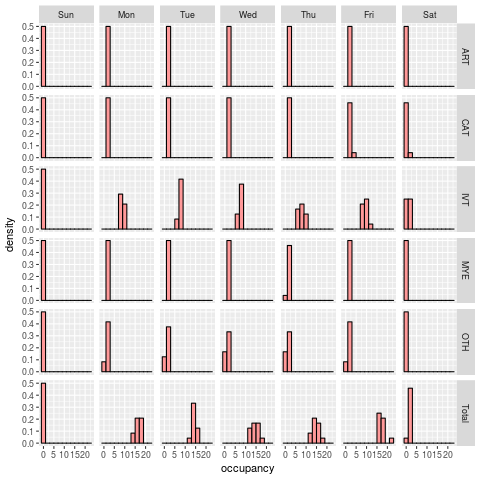

In [32]:
%%R
g2 <- ggplot(data=meanoccdate_df) + geom_histogram(aes(x=occupancy, y=..density..), binwidth=2, fill="#FF9999", colour="black")
print(g2 + facet_grid(patient_type ~ dayofweek))

And now we've got the DOW ordering we really wanted. This has been a quick tour of plotting occupancy data using ggplot2 from within an IPython notebook. Future installments of this series of occupancy analysis will focus on more occupancy visualizations using some combination of R and Python.
